In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

In [3]:
class InsuranceCallCenterSimulation:
    def __init__(self, call_arrival_rate, answer_time_func, claim_time_func, info_time_func, sim_duration):
        
        # Parameters
        self.call_arrival_rate = call_arrival_rate
        self.answer_time_func = answer_time_func
        self.claim_time_func = claim_time_func
        self.info_time_func = info_time_func
        self.sim_duration = sim_duration
        
        self.rng = np.random.default_rng()
        
        # States
        self.time = 0
        self.calls = 0
        self.events_queue = []
        self.events = {
            'call_arrival': self.process_call_arrival,
            'end_answer': self.end_answer,
            'end_claim': self.end_claim,
            'end_info': self.end_info,
        }
        
        # Queues and servers
        self.answer_queue = deque()
        self.answer_status = -1
        self.claim_queue= deque()
        self.claim_status = [-1] * 3
        self.info_queue = deque()
        self.info_status = [-1] * 7
        
        # Statistics data 
        self.call_arrivals = {}
        self.answer_start = {}
        self.answer_end = {}
        self.claim_start = {}
        self.claim_end = {}
        self.info_start = {}
        self.info_end = {}
        self.call_exit = {}
        self.call_path = {}
        self.answer_queue_lengths = []  
        self.claim_queue_lengths = []   
        self.info_queue_lengths = []    
        self.answer_busy_time = 0
        self.claim_busy_times = [0] * 3
        self.info_busy_times = [0] * 7
        self.claim_server_counts = [0] * 3
        self.info_server_counts = [0] * 7
        self.last_time = 0
        
    #Generate arrivals
    def next_call_arrival(self):
        if self.time >= self.sim_duration:
            return
        time_arrival = self.rng.exponential(1 / (self.call_arrival_rate))
        next_time = self.time + time_arrival
        if next_time < self.sim_duration:
            heapq.heappush(self.events_queue, (next_time, 'call_arrival'))
    
    #Process queues, servers and events 
    def process_call_arrival(self):
        self.answer_queue_lengths.append((self.time, len(self.answer_queue)))
        self.claim_queue_lengths.append((self.time, len(self.claim_queue)))
        self.info_queue_lengths.append((self.time, len(self.info_queue)))
        
        call_id = self.calls
        self.calls += 1
        self.call_arrivals[call_id] = self.time
        self.call_path[call_id] = []
        
        if self.answer_status == -1:
            self.process_answer(call_id)
        else:
            self.answer_queue.append(call_id)
        
        self.next_call_arrival()
    
    def process_answer(self, call_id):
        self.answer_status = call_id
        self.answer_start[call_id] = self.time
        duration = self.answer_time_func()
        heapq.heappush(self.events_queue, (self.time + duration, 'end_answer', call_id))
    
    def process_claim(self, server_idx, call_id):
        self.claim_status[server_idx] = call_id
        self.claim_start[call_id] = self.time
        duration = self.claim_time_func()
        heapq.heappush(self.events_queue, (self.time + duration, 'end_claim', server_idx))
    
    def process_info(self, server_idx, call_id):
        self.info_status[server_idx] = call_id
        self.info_start[call_id] = self.time
        duration = self.info_time_func()
        heapq.heappush(self.events_queue, (self.time + duration, 'end_info', server_idx))
    
    def end_answer(self, call_id):
        self.answer_queue_lengths.append((self.time, len(self.answer_queue)))
        self.claim_queue_lengths.append((self.time, len(self.claim_queue)))
        self.info_queue_lengths.append((self.time, len(self.info_queue)))
        
        assert self.answer_status == call_id
        self.answer_end[call_id] = self.time
        self.answer_busy_time += self.time - self.answer_start[call_id]
        
        if self.answer_queue:
            next_call_id = self.answer_queue.popleft()
            self.process_answer(next_call_id)
        else:
            self.answer_status = -1
        
        if self.rng.random() < 0.55:
            self.call_path[call_id].append('claim')
            # Check if any claim server is free
            for server_idx in range(3):
                if self.claim_status[server_idx] == -1:
                    self.process_claim(server_idx, call_id)
                    break
            else:
                self.claim_queue.append(call_id)
        else:
            self.call_path[call_id].append('info')
            for server_idx in range(7):
                if self.info_status[server_idx] == -1:
                    self.process_info(server_idx, call_id)
                    break
            else:
                self.info_queue.append(call_id)
    
    def end_claim(self, server_idx):
        self.answer_queue_lengths.append((self.time, len(self.answer_queue)))
        self.claim_queue_lengths.append((self.time, len(self.claim_queue)))
        self.info_queue_lengths.append((self.time, len(self.info_queue)))
        
        assert self.claim_status[server_idx] != -1
        call_id = self.claim_status[server_idx]
        self.claim_end[call_id] = self.time
        self.claim_busy_times[server_idx] += self.time - self.claim_start[call_id]
        self.claim_server_counts[server_idx] += 1
        
        if self.claim_queue:
            next_call_id = self.claim_queue.popleft()
            self.process_claim(server_idx, next_call_id)
        else:
            self.claim_status[server_idx] = -1
        
        if self.rng.random() < 0.02:
            self.call_path[call_id].append('info')
            for server_idx_info in range(7):
                if self.info_status[server_idx_info] == -1:
                    self.process_info(server_idx_info, call_id)
                    break
            else:
                self.info_queue.append(call_id)
        else:
            self.call_exit[call_id] = self.time
    
    def end_info(self, server_idx):
        self.answer_queue_lengths.append((self.time, len(self.answer_queue)))
        self.claim_queue_lengths.append((self.time, len(self.claim_queue)))
        self.info_queue_lengths.append((self.time, len(self.info_queue)))
        
        assert self.info_status[server_idx] != -1
        call_id = self.info_status[server_idx]
        self.info_end[call_id] = self.time
        self.info_busy_times[server_idx] += self.time - self.info_start[call_id]
        self.info_server_counts[server_idx] += 1
        
        if self.info_queue:
            next_call_id = self.info_queue.popleft()
            self.process_info(server_idx, next_call_id)
        else:
            self.info_status[server_idx] = -1
        
        if self.rng.random() < 0.01:
            self.call_path[call_id].append('claim')
            for server_idx_claim in range(3):
                if self.claim_status[server_idx_claim] == -1:
                    self.process_claim(server_idx_claim, call_id)
                    break
            else:
                self.claim_queue.append(call_id)
        else:
            self.call_exit[call_id] = self.time
    
    #Run the simulation 
    def run(self):
        self.next_call_arrival()
        while self.events_queue:
            event = heapq.heappop(self.events_queue)
            self.time = event[0]
            event_type = event[1]
            args = event[2:] if len(event) > 2 else ()
            self.events[event_type](*args)
    
    #Calculate statistics
    def statistics(self):
        system_times = []
        answer_times = []
        claim_times = []
        info_times = []
        answer_wait_times = []
        claim_wait_times = []
        info_wait_times = []
        path_counts = {
            'claim': 0,
            'information': 0,
            'claim_info': 0,
            'info_claim': 0,
        }
        
        # Calculate times
        for call_id in self.call_arrivals:
            if call_id in self.call_exit:
                system_times.append(self.call_exit[call_id] - self.call_arrivals[call_id])
            if call_id in self.answer_end:
                answer_times.append(self.answer_end[call_id] - self.call_arrivals[call_id])
            if call_id in self.claim_end:
                claim_times.append(self.claim_end[call_id] - self.claim_start[call_id])
            if call_id in self.info_end:
                info_times.append(self.info_end[call_id] - self.info_start[call_id])
            if call_id in self.answer_start:
                answer_wait_times.append(self.answer_start[call_id] - self.call_arrivals[call_id])
            if call_id in self.claim_start and call_id in self.answer_end:
                claim_wait_times.append(self.claim_start[call_id] - self.answer_end[call_id])
            if call_id in self.info_start and call_id in self.answer_end:
                info_wait_times.append(self.info_start[call_id] - self.answer_end[call_id])
            
            # Classify trajectories
            path = self.call_path.get(call_id, [])
            if path == ['claim']:
                path_counts['claim'] += 1
            elif path == ['info']:
                path_counts['information'] += 1
            elif path == ['claim', 'info']:
                path_counts['claim_info'] += 1
            elif path == ['info', 'claim']:
                path_counts['info_claim'] += 1
         
        # Convert times 
        system_times = [t * 60 for t in system_times]  
        answer_times = [t * 60 for t in answer_times]  
        answer_wait_times = [t * 60 for t in answer_wait_times]
        claim_wait_times = [t * 60 for t in claim_wait_times]
        info_wait_times = [t * 60 for t in info_wait_times]
        claim_times = [t * 60 for t in claim_times]
        info_times = [t * 60 for t in info_times]
        
        # Calculate average queue lengths weighted by time
        total_time = self.time
        avg_answer_queue = 0
        avg_claim_queue = 0
        avg_info_queue = 0
        if total_time > 0:
            for i in range(len(self.answer_queue_lengths) - 1):
                time_delta = self.answer_queue_lengths[i + 1][0] - self.answer_queue_lengths[i][0]
                avg_answer_queue += self.answer_queue_lengths[i][1] * time_delta
                avg_claim_queue += self.claim_queue_lengths[i][1] * time_delta
                avg_info_queue += self.info_queue_lengths[i][1] * time_delta
            avg_answer_queue /= total_time
            avg_claim_queue /= total_time
            avg_info_queue /= total_time
        
        # Calculate utilization
        utilization_answer = (self.answer_busy_time / total_time) * 100 if total_time > 0 else 0
        utilization_claim = [(t / total_time) * 100 for t in self.claim_busy_times] if total_time > 0 else [0] * 3
        utilization_info = [(t / total_time) * 100 for t in self.info_busy_times] if total_time > 0 else [0] * 7
        
        return {
            'avg_answer_queue': avg_answer_queue,
            'avg_claim_queue': avg_claim_queue,
            'avg_info_queue': avg_info_queue,
            'answer_queue_lengths': [l for _, l in self.answer_queue_lengths],
            'claim_queue_lengths': [l for _, l in self.claim_queue_lengths],
            'info_queue_lengths': [l for _, l in self.info_queue_lengths],
            'system_times': system_times,
            'answer_times': answer_times,
            'claim_times': claim_times,
            'info_times': info_times,
            'answer_wait_times': answer_wait_times,
            'claim_wait_times': claim_wait_times,
            'info_wait_times': info_wait_times,
            'path_counts': path_counts,
            'utilization_answer': utilization_answer,
            'utilization_claim': utilization_claim,
            'utilization_info': utilization_info,
            'claim_server_counts': self.claim_server_counts,
            'info_server_counts': self.info_server_counts,
        }


In [4]:
sim = InsuranceCallCenterSimulation(
    call_arrival_rate=35,
    answer_time_func=lambda: np.random.exponential(30/3600),
    claim_time_func=lambda: np.random.exponential(6/60),
    info_time_func=lambda: np.random.exponential(20/60),
    sim_duration=24
)
sim.run()
stats = sim.statistics()

## Tamaño promedio de la cola en el contestador
Calculamos el tamaño promedio de la cola de llamadas esperando al contestador. El histograma muestra la distribución de las longitudes de la cola observadas durante la simulación.

Tamaño promedio de la cola en el contestador: 0.07 llamadas


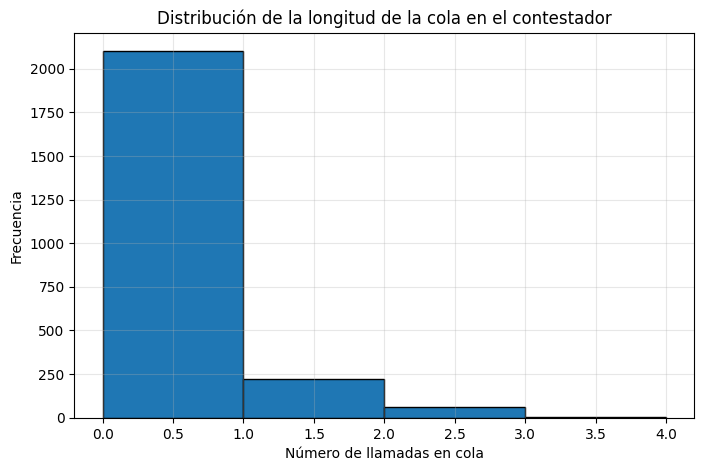

In [5]:
avg_answer_queue = stats['avg_answer_queue']

print(f"Tamaño promedio de la cola en el contestador: {avg_answer_queue:.2f} llamadas")

plt.figure(figsize=(8, 5))
plt.hist(stats['answer_queue_lengths'], bins=range(max(stats['answer_queue_lengths'], default=1) + 2), edgecolor='black')
plt.title('Distribución de la longitud de la cola en el contestador')
plt.xlabel('Número de llamadas en cola')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

## Tamaño promedio de la cola en el nodo de reclamaciones
Calculamos el tamaño promedio de las colas en los tres servidores de reclamaciones. El histograma muestra la distribución de las longitudes totales observadas.

Tamaño promedio de la cola en reclamaciones: 0.60 llamadas


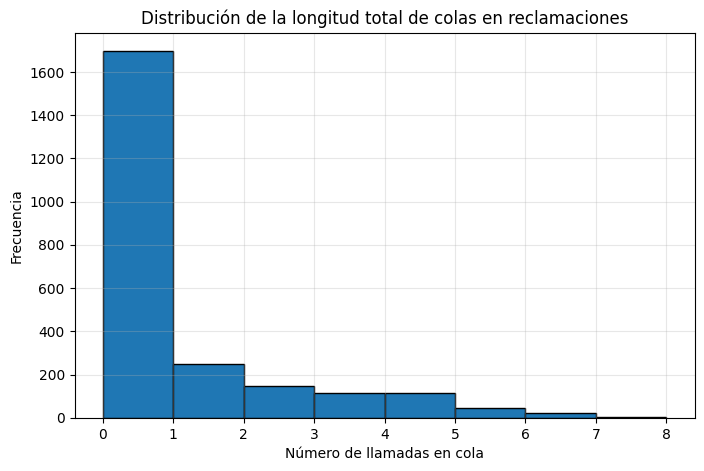

In [6]:
avg_claim_queue = stats['avg_claim_queue']

print(f"Tamaño promedio de la cola en reclamaciones: {avg_claim_queue:.2f} llamadas")

plt.figure(figsize=(8, 5))
plt.hist(stats['claim_queue_lengths'], bins=range(max(stats['claim_queue_lengths'], default=1) + 2), edgecolor='black')
plt.title('Distribución de la longitud total de colas en reclamaciones')
plt.xlabel('Número de llamadas en cola')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

## Tamaño promedio de la cola en el nodo de información
Calculamos el tamaño promedio de las colas en los siete servidores de información. El histograma muestra la distribución de las longitudes totales observadas.

Tamaño promedio de la cola en información: 1.28 llamadas


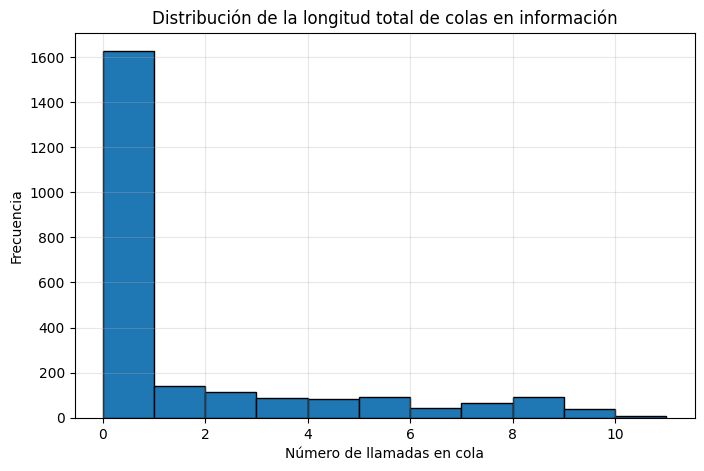

In [7]:
avg_info_queue = stats['avg_info_queue']

print(f"Tamaño promedio de la cola en información: {avg_info_queue:.2f} llamadas")

plt.figure(figsize=(8, 5))
plt.hist(stats['info_queue_lengths'], bins=range(max(stats['info_queue_lengths'], default=1) + 2), edgecolor='black')
plt.title('Distribución de la longitud total de colas en información')
plt.xlabel('Número de llamadas en cola')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
plt.show()

## Tiempo de espera en cola por servicio
Se calculan los tiempos promedio de espera en cada cola. El diagrama de caja muestra la distribución de estos tiempos.

Tiempo promedio de espera en cola para contestador: 0.14 minutos
Tiempo promedio de espera en cola para reclamaciones: 2.18 minutos
Tiempo promedio de espera en cola para información: 5.29 minutos


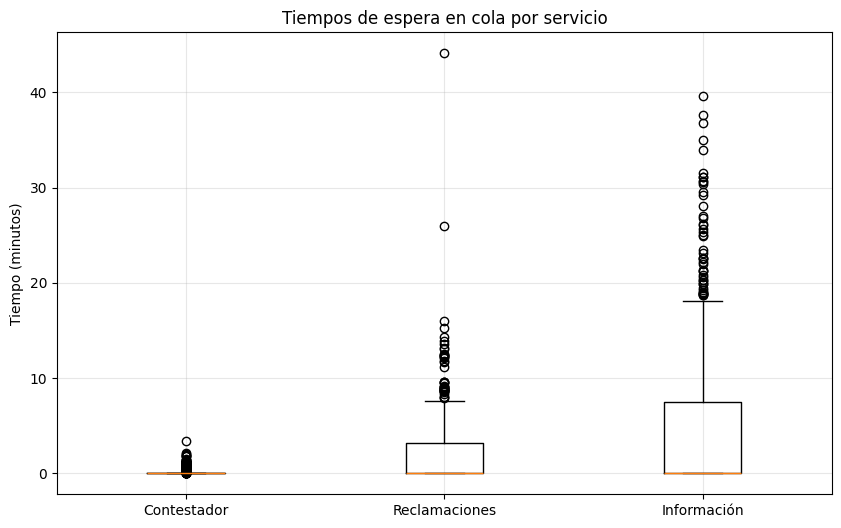

In [8]:
avg_answer_wait = np.mean(stats['answer_wait_times']) if stats['answer_wait_times'] else 0
avg_claim_wait = np.mean(stats['claim_wait_times']) if stats['claim_wait_times'] else 0
avg_info_wait = np.mean(stats['info_wait_times']) if stats['info_wait_times'] else 0

print(f"Tiempo promedio de espera en cola para contestador: {avg_answer_wait:.2f} minutos")
print(f"Tiempo promedio de espera en cola para reclamaciones: {avg_claim_wait:.2f} minutos")
print(f"Tiempo promedio de espera en cola para información: {avg_info_wait:.2f} minutos")

plt.figure(figsize=(10, 6))
plt.boxplot([stats['answer_wait_times'], stats['claim_wait_times'], stats['info_wait_times']],
            tick_labels=['Contestador', 'Reclamaciones', 'Información'])
plt.title('Tiempos de espera en cola por servicio')
plt.ylabel('Tiempo (minutos)')
plt.grid(True, alpha=0.3)
plt.show()

## Cantidad de llamadas por servidor
El gráfico de barras muestra la cantidad de llamadas por serividor, teniendo en cuenta que son 3 servidores de revlamaciones (Reclam.) y 7 servidores de información (Info.). 

Llamadas atendidas por servidor de reclamaciones: [179, 144, 105]
Llamadas atendidas por servidor de información: [67, 72, 52, 59, 51, 35, 40]


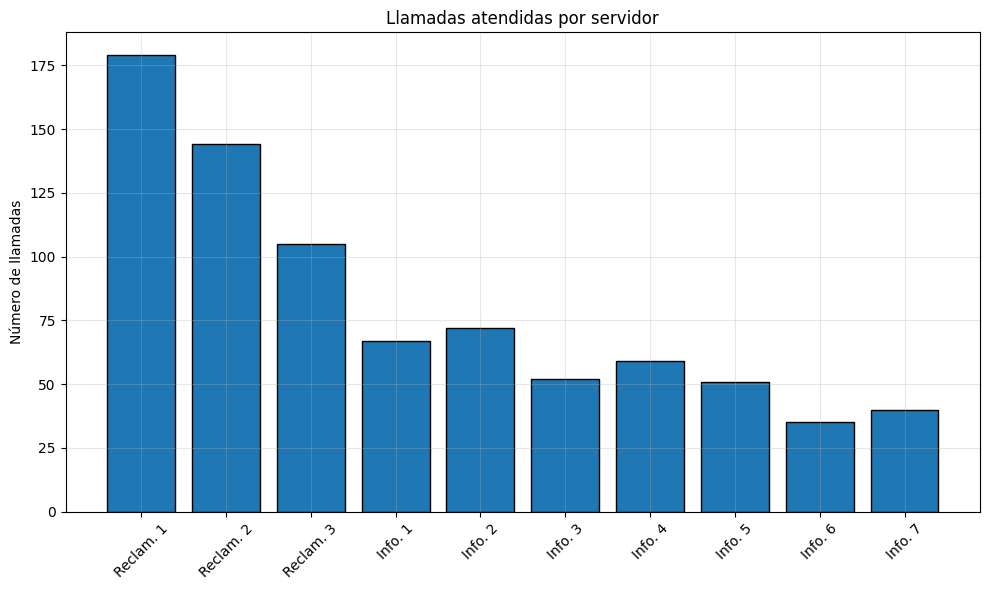

In [9]:
print(f"Llamadas atendidas por servidor de reclamaciones: {stats['claim_server_counts']}")
print(f"Llamadas atendidas por servidor de información: {stats['info_server_counts']}")

plt.figure(figsize=(10, 6))
plt.bar([f'Reclam. {i+1}' for i in range(3)] + [f'Info. {i+1}' for i in range(7)],
        stats['claim_server_counts'] + stats['info_server_counts'], edgecolor='black')
plt.title('Llamadas atendidas por servidor')
plt.ylabel('Número de llamadas')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Utilización de los servidores 
En el gráfico de abajo se muestra el porcentaje de tiempo que pasa cada servidor ocupado.


Utilización del contestador: 25.78%
Utilización de servidores de reclamaciones: ['72.86%', '59.14%', '47.46%']
Utilización de servidores de información: ['89.60%', '82.92%', '75.94%', '74.45%', '63.78%', '59.34%', '47.64%']


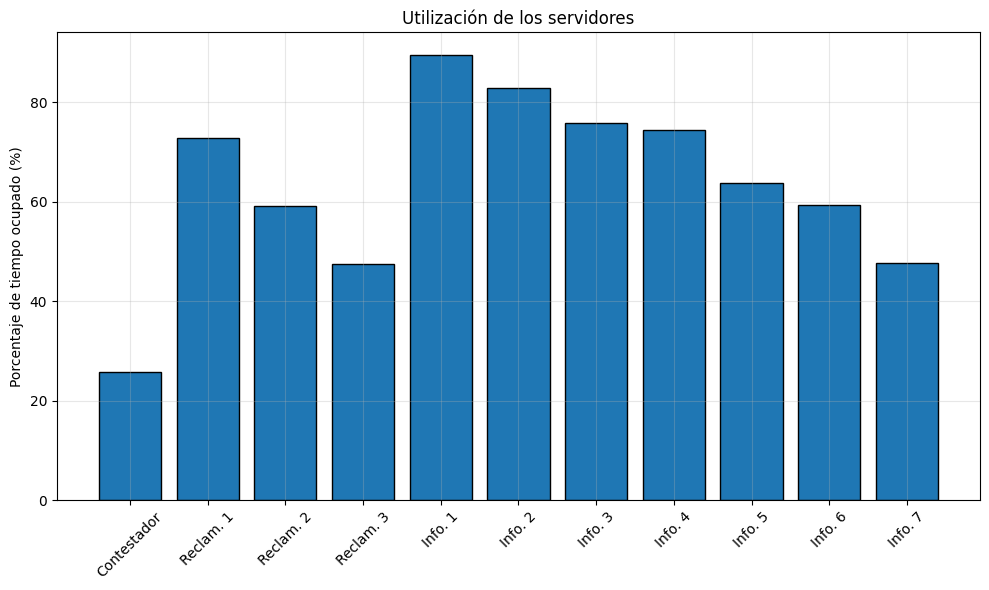

In [11]:
print(f"Utilización del contestador: {stats['utilization_answer']:.2f}%")
print(f"Utilización de servidores de reclamaciones: {[f'{u:.2f}%' for u in stats['utilization_claim']]}")
print(f"Utilización de servidores de información: {[f'{u:.2f}%' for u in stats['utilization_info']]}")

plt.figure(figsize=(10, 6))
plt.bar(['Contestador'] + [f'Reclam. {i+1}' for i in range(3)] + [f'Info. {i+1}' for i in range(7)],
        [stats['utilization_answer']] + stats['utilization_claim'] + stats['utilization_info'],
        edgecolor='black')
plt.title('Utilización de los servidores')
plt.ylabel('Porcentaje de tiempo ocupado (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cantidad de llamadas por trayectoria 

Se muestran la cantidad de llamadas por trayectoria posible:
- Solo reclamaciones
- Solo informacion
- Reclamaciones a informacion
- Informacion a reclamaciones

Número de llamadas por trayectoria:
Solo reclamaciones: 417
Solo información: 365
Reclamaciones a información: 9
Información a reclamaciones: 2


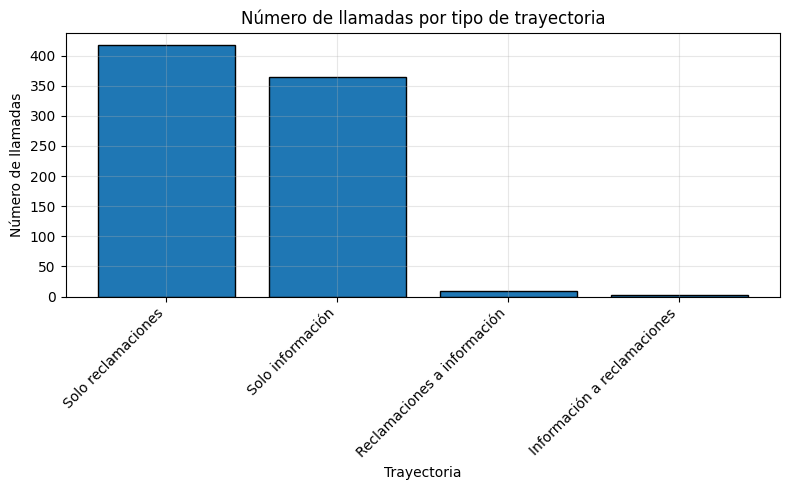

In [12]:
path_counts = stats['path_counts']
translations = {
    'claim': 'Solo reclamaciones',
    'information': 'Solo información',
    'claim_info': 'Reclamaciones a información',
    'info_claim': 'Información a reclamaciones',
}

print("Número de llamadas por trayectoria:")
for path, count in path_counts.items():
    print(f"{translations[path]}: {count}")

plt.figure(figsize=(8, 5))
plt.bar([translations[path] for path in path_counts.keys()], path_counts.values(), edgecolor='black')
plt.title('Número de llamadas por tipo de trayectoria')
plt.xlabel('Trayectoria')
plt.ylabel('Número de llamadas')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Tiempo medio que un cliente pasa en el sistema
Calculamos el tiempo promedio que una llamada pasa desde que llega hasta que sale del sistema, incluyendo todas las etapas (contestador, reclamaciones, información). El gráfico muestra los tiempos de cada llamada completada.

Tiempo medio en el sistema: 16.39 minutos


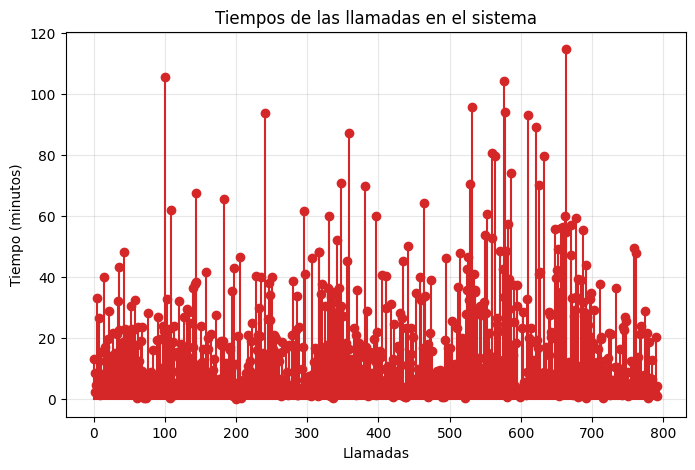

In [13]:
avg_system_time = np.mean(stats['system_times']) if stats['system_times'] else 0
print(f"Tiempo medio en el sistema: {avg_system_time:.2f} minutos")

plt.figure(figsize=(8, 5))
plt.stem(range(len(stats['system_times'])), stats['system_times'], 'C3-')
plt.title('Tiempos de las llamadas en el sistema')
plt.xlabel('Llamadas')
plt.ylabel('Tiempo (minutos)')
plt.grid(True, alpha=0.3)
plt.show()